The architectiure consists of three main parts
- Image linear projection and additional embeddings
- Pure transformer structure
- MLP Classifier head

In [50]:
import os
import shutil
import pandas as pd

# Set the path to the directory containing JPEG files
image_folder = './data/train/'

# Set the path to the CSV file
csv_file = './data/Training_set.csv'

# Set the output directory for classes
output_folder = './data/train_folder/'

# Read the CSV file
df = pd.read_csv(csv_file)

# Iterate through each row in the CSV file
for index, row in df.iterrows():
    # Extract filename and class
    filename = row['filename']
    image_class = row['label']

    # Set the source and destination paths
    source_path = os.path.join(image_folder, filename)
    destination_folder = os.path.join(output_folder, image_class)
    destination_path = os.path.join(destination_folder, filename)

    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # Move the file to the destination
    shutil.move(source_path, destination_path)

print("Files moved successfully.")


Files moved successfully.


# 1. Image linear projection and additional embeddings
## 1.1 Read image into pytorch dataloader

In [201]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [152]:
# Train image size define in Table 3 
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [153]:
train_dataset = datasets.ImageFolder('./data/train_folder/', transform=manual_transforms)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
)
classes = train_dataset.classes

In [154]:
random_sample_idx = torch.randint(0, len(train_dataloader), (1,)).item()

image = train_dataloader.dataset[random_sample_idx][0]
label = classes[train_dataloader.dataset[random_sample_idx][1]]

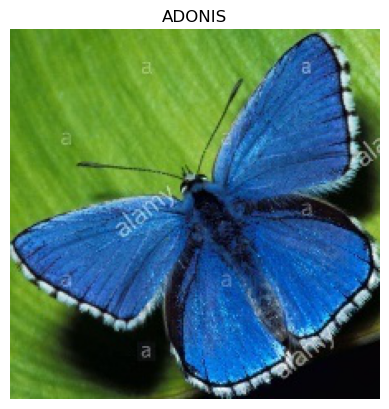

In [155]:
plt.imshow(image.permute(1,2,0))
plt.title(label)
plt.axis(False);

## 1.2 Split image into patches

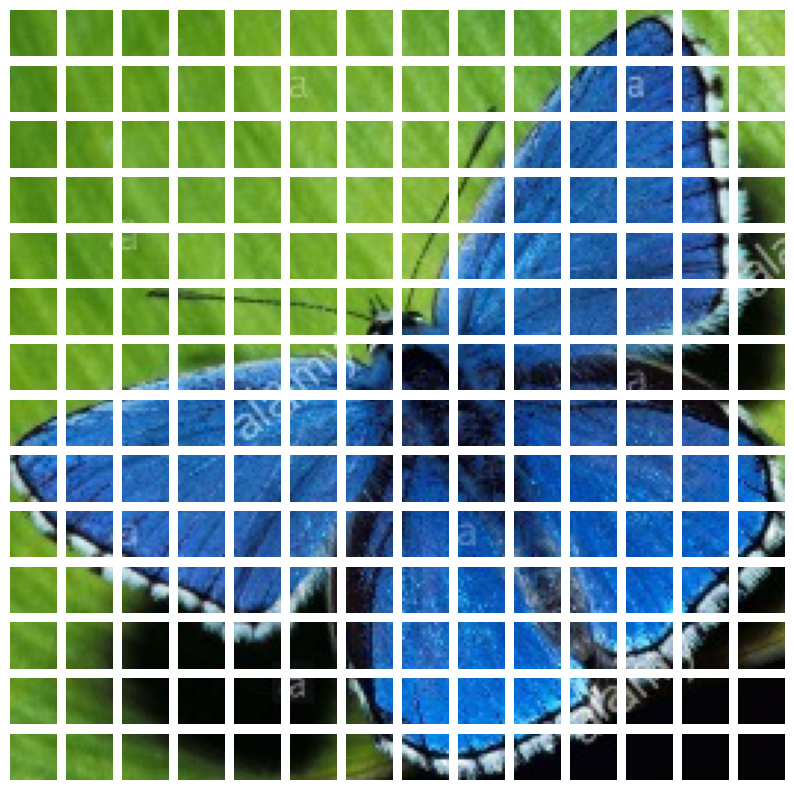

In [187]:
patch_size = 16

height, width = image.shape[1:]

num_rows = width // patch_size
num_cols = height // patch_size

patches = []

fig, axs = plt.subplots(num_rows, num_cols, figsize=(10,10))

for c in range(num_cols):
    for r in range(num_rows):
        patch = image[
            :, # Color dim
            c * patch_size : (c + 1) * patch_size, # height dim
            r * patch_size : (r + 1) * patch_size # width dim
        ]
        patches.append(patch)
        
        axs[c,r].imshow(patch.permute(1,2,0))
        axs[c,r].axis(False)



## 1.3 Flatten the 2D patches into 1D

In [337]:
unfold = nn.Unfold(kernel_size=(16, 16), stride=16)
unfolded_image = unfold(image.unsqueeze(0))
unfolded_image.shape

torch.Size([1, 768, 196])

## 1.4 Class Embedding

In [340]:
class_embedding = nn.Parameter(torch.randn(1, 768), requires_grad=True)
class_embedding.shape

torch.Size([1, 768])

In [348]:
class_embedded_unfolded_image = torch.cat((unfolded_image.permute(0,2,1), class_embedding.unsqueeze(0)), dim=1)
class_embedded_unfolded_image.shape

torch.Size([1, 197, 768])

## 1.5 Position Embedding

In [349]:
position_embedding = nn.Parameter(torch.randn(1, 768), requires_grad=True)
position_embedding.shape

torch.Size([1, 768])

In [353]:
position_class_embedded_unfolded_image = class_embedded_unfolded_image + position_embedding.unsqueeze(0)
position_class_embedded_unfolded_image.shape

torch.Size([1, 197, 768])

In [399]:
class ProjectorEmbedder(nn.Module):
    """
        ProjectionEmbeddings class implements a module for projecting input data into embeddings using patches,
        class embedding, and position embedding.

        Parameters:
        - patch_size (int): The size of the patches used for projection.
        - embedding_size (int): The size of the output embeddings.

        Attributes:
        - unfold (nn.Unfold): Unfolding operation for extracting patches from input data.
        - class_emb (nn.Parameter): Learnable parameter for class embedding.
        - position_emb (nn.Parameter): Learnable parameter for position embedding.
    """
    
    def __init__(self, patch_size:int, embedding_size:int):
        super().__init__()
        
        # Converting 2D image into 1D vector
        # Paper Reference: Equation 1, Figure 1
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        
        # Create a learnable class embedding
        # Paper Reference: Equation 1, Figure 1
        self.class_emb = nn.Parameter(torch.randn(1, embedding_size), requires_grad=True)
        
        # Create a learnable position embedding
        # Paper Reference: Equation 1, Figure 1
        self.position_emb = nn.Parameter(torch.randn(1, embedding_size), requires_grad=True)
    
    def forward(self, x):
        # Patch and flatten the image
        x = unfold(x)
        
        # Prepend class embedding to image vector 
        # Paper reference: Equation 1, Figure 1
        x = torch.cat((x.permute(1, 0), self.class_emb), dim=0)

        # Add position embedding to class embeddings  
        # and image vector changing the data 
        # Paper Reference: Equation 1, Figure 1 and D.4
        return x + self.position_emb

In [401]:
projector_embedder = ProjectorEmbedder(16, 768)
projected_embedded_image = projector_embedder(image)
projected_embedded_image.shape

torch.Size([197, 768])

# 2. Transformer

In [ ]:
nn.TransformerEncoderLayer(
    d_model= 768, 
    nhead= 12,
    dim_feedforward=3072,
    dropout=0,
    activation='gelu',
    norm_first=True,
    batch_first=True
)

In [409]:
transformer = nn.TransformerEncoderLayer(
    # Constant latent vector size D
    # Paper Reference : Equation 1
    d_model= 768, 
    # Depending on the delevoped model
    # ViT-Base 16= 12
    # Paper Reference: Table 1 
    nhead= 12, 
    # Depending on the delevoped model
    # ViT-Base 16= 3072
    # Paper Reference: Table 1 
    dim_feedforward=3072,
    # Depending on the delevoped model and dataset
    # ViT-Base 16 - JFT-300M= 0
    # Paper Reference: Table 3
    dropout=0,
    # Paper Reference: Section 3.1
    activation='gelu',
    # Paper Reference: Figure 1
    norm_first=True,
    # Batch is the first dimension
    batch_first=True
)
transformer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0, inplace=False)
  (dropout2): Dropout(p=0, inplace=False)
)

In [410]:
transformer_stack = nn.TransformerEncoder(
    transformer, 
    # Paper Reference: Table 1
    num_layers=12,
    enable_nested_tensor=False
)
transformer_stack

TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0, inplace=False)
      (dropout2): Dropout(p=0, inplace=False)
    )
  )
)

In [414]:
transformer_stack_output = transformer_stack(projected_embedded_image)
transformer_stack_output.shape

torch.Size([197, 768])

# 3. MLP Head (Classifier)


In [427]:
classifier = nn.Sequential(
    nn.LayerNorm(normalized_shape=768),
    nn.Linear(in_features=768, out_features=len(classes))
)

classifier(transformer_stack_output).shape

torch.Size([197, 75])